In [10]:
# upload audio file
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))

Saving voice4.wav to voice4 (1).wav


In [11]:
num_speakers = 6 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'medium' #@param ['tiny', 'base', 'small', 'medium', 'large']

model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'

In [12]:
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null

In [13]:


import whisper
import datetime

import subprocess

import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/root/.cache/torch/pyannote/speechbrain/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hug

In [14]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
  path = 'audio.wav'

In [16]:
model = whisper.load_model(model_size)
result = model.transcribe(path)
print("result:\n" +str(result))
segments = result["segments"]
print("segments:\n" +str(segments))

result:
{'text': " While I agree with my friends that AI has the capacity to replicate and humans don't, but I beg to disagree on this point that this particular quality is something which allows it to surpass human capacity because the fact that humans can't replicate themselves is a mere is makes it very evident that you cannot predict how human development will take place 50 years down the line or 100 years down the line. It will be replacing us but I think the AI has the capacity. We never thought the industries will be doing the job that has been done by the laborers before and that followed the industrial revolution. So I think that AI will replace humans for a while that will be followed by a revolution and then we will come with some reforms and law that will help us to have a simpatic relation between both of us. Hello everyone, good afternoon. Good afternoon sir. Your topic for the group discussion is will AI ever replace humans? You have about three minutes to prepare your p

In [18]:
for results in result:
  print(results)

text
segments
language


In [17]:
for seg in segments:
  print(seg)

{'id': 0, 'seek': 0, 'start': 0.0, 'end': 6.5600000000000005, 'text': " While I agree with my friends that AI has the capacity to replicate and humans don't,", 'tokens': [50364, 3987, 286, 3986, 365, 452, 1855, 300, 7318, 575, 264, 6042, 281, 25356, 293, 6255, 500, 380, 11, 50692], 'temperature': 0.0, 'avg_logprob': -0.150643980180895, 'compression_ratio': 1.6602870813397128, 'no_speech_prob': 0.16752327978610992}
{'id': 1, 'seek': 0, 'start': 6.5600000000000005, 'end': 14.24, 'text': ' but I beg to disagree on this point that this particular quality is something which allows it', 'tokens': [50692, 457, 286, 4612, 281, 14091, 322, 341, 935, 300, 341, 1729, 3125, 307, 746, 597, 4045, 309, 51076], 'temperature': 0.0, 'avg_logprob': -0.150643980180895, 'compression_ratio': 1.6602870813397128, 'no_speech_prob': 0.16752327978610992}
{'id': 2, 'seek': 0, 'start': 14.24, 'end': 19.76, 'text': " to surpass human capacity because the fact that humans can't replicate themselves is", 'tokens': [5

In [19]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)
  print("total duration of audio in sec.= " +str(duration))

total duration of audio in sec.= 211.04104308390023


In [20]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  # Resample to mono if necessary
  if waveform.shape[0] > 1:#mono means 1frame=1 sample
      waveform = waveform[0, :].unsqueeze(0) # Take the first channel and keep the batch dimension
  return embedding_model(waveform[None])

In [21]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)
print (embeddings)

[[  2.38174558  42.73566818 -24.49290657 ...  28.31582832  44.48984909
  -20.11805916]
 [ -6.99662638  29.70242691 -10.43740368 ...  26.12297058  16.67708588
  -18.05892372]
 [-10.44479084  49.32539749 -24.48464012 ...  33.20462036  25.61697197
  -17.00863838]
 ...
 [ 19.34226418  18.3172245  -34.53227615 ... -11.78792     14.31318951
   15.1625948 ]
 [ 16.60585022  32.86248779 -23.60027504 ... -12.51520443  13.14229202
    7.41417217]
 [ 34.43877029   7.64775944   9.34349823 ...  16.37789154  11.39933491
   13.91991138]]


In [22]:
clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)
  # print(segments[i]["speaker"])#print speaker
  print(segments[i])

{'id': 0, 'seek': 0, 'start': 0.0, 'end': 6.5600000000000005, 'text': " While I agree with my friends that AI has the capacity to replicate and humans don't,", 'tokens': [50364, 3987, 286, 3986, 365, 452, 1855, 300, 7318, 575, 264, 6042, 281, 25356, 293, 6255, 500, 380, 11, 50692], 'temperature': 0.0, 'avg_logprob': -0.150643980180895, 'compression_ratio': 1.6602870813397128, 'no_speech_prob': 0.16752327978610992, 'speaker': 'SPEAKER 1'}
{'id': 1, 'seek': 0, 'start': 6.5600000000000005, 'end': 14.24, 'text': ' but I beg to disagree on this point that this particular quality is something which allows it', 'tokens': [50692, 457, 286, 4612, 281, 14091, 322, 341, 935, 300, 341, 1729, 3125, 307, 746, 597, 4045, 309, 51076], 'temperature': 0.0, 'avg_logprob': -0.150643980180895, 'compression_ratio': 1.6602870813397128, 'no_speech_prob': 0.16752327978610992, 'speaker': 'SPEAKER 1'}
{'id': 2, 'seek': 0, 'start': 14.24, 'end': 19.76, 'text': " to surpass human capacity because the fact that hum

In [23]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w")
for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')#write speaker and timestamp.
    print(" "+ segment["speaker"] + ' ' + str(time(segment["start"])) + " ")
  f.write(segment["text"][1:] + ' ')#write transcript of speaker
f.close()

 SPEAKER 1 0:00:00 
 SPEAKER 2 0:00:40 
 SPEAKER 3 0:00:51 
 SPEAKER 5 0:00:53 
 SPEAKER 6 0:00:55 
 SPEAKER 5 0:00:56 
 SPEAKER 4 0:01:12 
 SPEAKER 3 0:02:06 
 SPEAKER 2 0:02:41 
 SPEAKER 3 0:03:28 


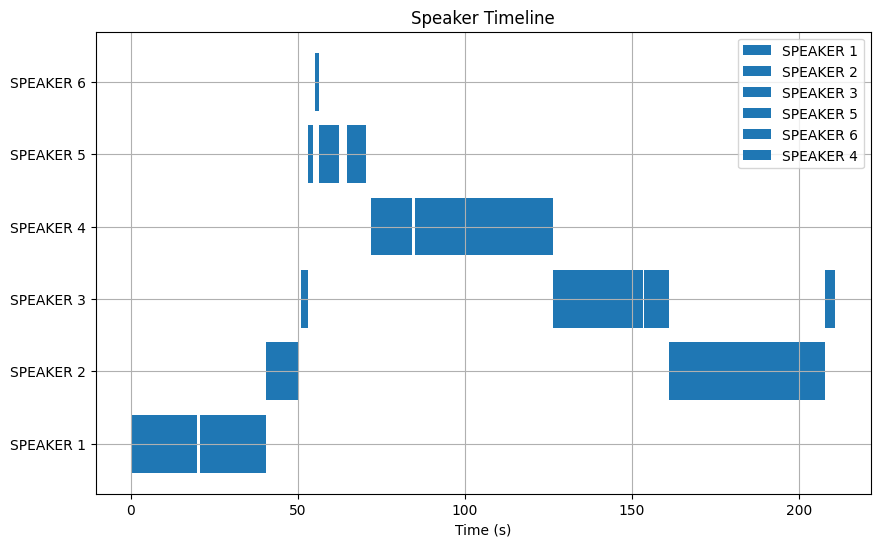

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


#  Collect speaker names
speakers = sorted(set(segment["speaker"] for segment in segments))

#  Map speakers to y-axis levels
speaker_to_y = {speaker: i for i, speaker in enumerate(speakers)}


fig, ax = plt.subplots(figsize=(10, len(speakers)))  # Dynamic height

for segment in segments:
    speaker = segment["speaker"]
    start = segment["start"]
    duration = segment["end"] - segment["start"]
    y = speaker_to_y[speaker]
    ax.broken_barh([(start, duration)], (y - 0.4, 0.8), label=speaker)

#  Formatting
ax.set_xlabel("Time (s)")
ax.set_yticks(list(speaker_to_y.values()))
ax.set_yticklabels(list(speaker_to_y.keys()))
ax.set_title("Speaker Timeline")
ax.grid(True)

#  remove duplicate legends
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.show()


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


In [26]:
pip install pyannote.metrics


In [27]:
for segment in segments:
    print("start:", segment["start"], "end:", segment["end"], "speaker:", segment["speaker"])


start: 0.0 end: 6.5600000000000005 speaker: SPEAKER 1
start: 6.5600000000000005 end: 14.24 speaker: SPEAKER 1
start: 14.24 end: 19.76 speaker: SPEAKER 1
start: 20.64 end: 27.52 speaker: SPEAKER 1
start: 27.599999999999998 end: 30.8 speaker: SPEAKER 1
start: 30.8 end: 35.44 speaker: SPEAKER 1
start: 35.44 end: 40.32 speaker: SPEAKER 1
start: 40.32 end: 46.8 speaker: SPEAKER 2
start: 46.8 end: 50.32 speaker: SPEAKER 2
start: 50.879999999999995 end: 53.04 speaker: SPEAKER 3
start: 53.04 end: 54.56 speaker: SPEAKER 5
start: 55.2 end: 56.400000000000006 speaker: SPEAKER 6
start: 56.400000000000006 end: 62.160000000000004 speaker: SPEAKER 5
start: 64.56 end: 70.48 speaker: SPEAKER 5
start: 71.76 end: 77.52000000000001 speaker: SPEAKER 4
start: 77.67999999999999 end: 84.24 speaker: SPEAKER 4
start: 84.96 end: 91.36 speaker: SPEAKER 4
start: 91.36 end: 96.24 speaker: SPEAKER 4
start: 96.24 end: 101.52 speaker: SPEAKER 4
start: 101.52 end: 109.52 speaker: SPEAKER 4
start: 109.52 end: 117.759999

In [28]:
# upload original label text file to compare with predicted one
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))

Saving voice4label.txt to voice4label (1).txt


In [29]:
import pandas as pd
# from google.colab import files

# # Upload the Audacity label file
# uploaded = files.upload()  # This will open a file chooser
# file_name = list(uploaded.keys())[0]  # Get the uploaded file name

# Read the label file
df = pd.read_csv(path, sep="\t", header=None, names=["start_time", "end_time", "speaker"])

# Save as CSV
# csv_file = path.replace(".txt", ".csv")
path = path.replace(".txt", ".csv")
df.to_csv(path, index=False)
# print(f"Saved CSV as {csv_file}")

# Optionally, download the CSV
# files.download(csv_file)


In [30]:
# Display header and a few rows

label_of_audio = pd.read_csv(f'{path}')
pd.set_option('display.max_columns', None) # viewing all the columns
display(label_of_audio)

,start_time,end_time,speaker
0,0.000000,30.741532,speaker1
1,30.741532,53.099010,speaker2
2,53.099010,71.391492,speaker3
3,71.391492,128.598162,speaker4
4,128.598162,158.153751,speaker5
5,158.153751,211.041042,speaker6


In [31]:
from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

# Build ground truth annotation
ref = Annotation()
for seg in label_of_audio.to_dict('records'):
    ref[Segment(seg["start_time"], seg["end_time"])] = seg["speaker"]

# Build hypothesis annotation
hyp = Annotation()
for seg in segments:
    hyp[Segment(seg["start"], seg["end"])] = seg["speaker"]

# Compute DER
der = DiarizationErrorRate()
score = der(ref, hyp)

print(f"Diarization Error Rate: {score*100:.2f}%")

Diarization Error Rate: 18.20%


/usr/local/lib/python3.11/dist-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
